# Implementation of the ETL method (Extract, Transform, Load)

## Extracting the Raw Data from the webpage
- First, import the libraries (pandas, requests, and BeautifulSoup)
- Choose a url (I chose a wikipedia page) and get the status code from the url
- If the code is 200, we can proceed with extracting data
- Next, parse wikipedia page with BeautifulSoup
- Find html with "table", and grab data from the 4th table (the one we want)
- Convert the raw data from the table to a pandas Dataframe

In [337]:
import pandas as pd 
import requests 
from bs4 import BeautifulSoup 
import numpy as np
wikiurl="https://en.wikipedia.org/wiki/List_of_municipalities_in_Texas"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)
# parse wikipedia page with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')
# since there are multiple tables in the webpage, grab data from the first table (the one we want)
txtable=soup.find_all('table')[0]
raw_data=pd.read_html(str(txtable))
# convert raw data from table to dataframe
raw_data=pd.DataFrame(raw_data[0])
raw_data.head()

200


2021 Rank Municipality Designation[8] Primary County  \
  2021 Rank Municipality Designation[8] Primary County   
0         1      Houston           City         Harris   
1         2  San Antonio           City          Bexar   
2         3       Dallas           City         Dallas   
3         4       Austin           City         Travis   
4         5   Fort Worth           City        Tarrant   

               Secondary County(ies)       Population                 \
               Secondary County(ies) 2021 Estimate[8] 2020 Census[1]   
0              Fort Bend, Montgomery          2288250        2304580   
1                      Medina, Comal          1451853        1434625   
2  Rockwall, Kaufman, Denton, Collin          1288457        1304379   
3                   Williamson, Hays           964177         961855   
4               Denton, Parker, Wise           935508         918915   

                                   
  2010 Census[9] 2010-2020 Change  
0        2099451           +9.77%  
1        1327407           +8.08%  
2        1197816           +8.90%  
3         790390          +21.69%  
4         741206          +23.98%

## Save the noisy, Raw Data to CSV

In [338]:
raw_data.to_csv("WikiTXCitiesPopulationRaw.csv")

## Transforming the Data
- Create dataframe variable that will contain the final data, name it "final_data"
- Drop unnecessary columns from the table (I kept the columns with land area and population density in 2020 with units of km^2 and dropped the columns with data in sq miles and location)
- Rename the remaining columns names and check result by printing the head

In [339]:
# drop the unwanted columns
raw_data.columns = raw_data.columns.droplevel(0)
final_data = raw_data.drop(["Secondary County(ies)"], axis = 1)


# rename columns for ease
final_data = final_data.rename(columns={"Designation[8]": "Designation","2021 Estimate[8]": "2021 Estimate", "2020 Census[1]":"2020 Census", "2010 Census[9]":"2010 Census","2010-2020 Change": "% Change"})

final_data.head()


,2021 Rank,Municipality,Designation,Primary County,2021 Estimate,2020 Census,2010 Census,% Change
0,1,Houston,City,Harris,2288250,2304580,2099451,+9.77%
1,2,San Antonio,City,Bexar,1451853,1434625,1327407,+8.08%
2,3,Dallas,City,Dallas,1288457,1304379,1197816,+8.90%
3,4,Austin,City,Travis,964177,961855,790390,+21.69%
4,5,Fort Worth,City,Tarrant,935508,918915,741206,+23.98%


## Perform Duplication checks on the data

In [340]:
number_of_duplicates = final_data.duplicated().sum()
print (f" Number of duplicates before : {number_of_duplicates}")


final_data = final_data.drop_duplicates()

number_of_duplicates = final_data.duplicated().sum()
print (f" Number of duplicates after removing : {number_of_duplicates}")

 Number of duplicates before : 0
 Number of duplicates after removing : 0


## Inspecting the data for noisy entries

In [341]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1223 entries, 0 to 1222
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   2021 Rank       1223 non-null   object
 1   Municipality    1223 non-null   object
 2   Designation     1223 non-null   object
 3   Primary County  1223 non-null   object
 4   2021 Estimate   1223 non-null   int64 
 5   2020 Census     1223 non-null   object
 6   2010 Census     1223 non-null   object
 7   % Change        1220 non-null   object
dtypes: int64(1), object(7)
memory usage: 86.0+ KB


## Drop the null entries

In [342]:
final_data = final_data.dropna()
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1220 entries, 0 to 1222
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   2021 Rank       1220 non-null   object
 1   Municipality    1220 non-null   object
 2   Designation     1220 non-null   object
 3   Primary County  1220 non-null   object
 4   2021 Estimate   1220 non-null   int64 
 5   2020 Census     1220 non-null   object
 6   2010 Census     1220 non-null   object
 7   % Change        1220 non-null   object
dtypes: int64(1), object(7)
memory usage: 85.8+ KB


## Drop data with dashed information (no value provided)

In [343]:
final_data = final_data.replace("-",np.nan)
final_data = final_data.drop(final_data.index[-2:])
final_data = final_data.dropna()
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1220
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   2021 Rank       1206 non-null   object
 1   Municipality    1206 non-null   object
 2   Designation     1206 non-null   object
 3   Primary County  1206 non-null   object
 4   2021 Estimate   1206 non-null   int64 
 5   2020 Census     1206 non-null   object
 6   2010 Census     1206 non-null   object
 7   % Change        1206 non-null   object
dtypes: int64(1), object(7)
memory usage: 84.8+ KB


## Perform cleaning by removing unnecessary strings from numerical data

In [344]:
def convert_strings_to_float(s):
    s = s.replace("%","")
    s = s.replace("−","-")
    s = s.replace(",","")
    s = s.replace("+","")
    converted = float(s)
    return converted


final_data["% Change"] = final_data["% Change"].apply(convert_strings_to_float)


final_data.head()


,2021 Rank,Municipality,Designation,Primary County,2021 Estimate,2020 Census,2010 Census,% Change
0,1,Houston,City,Harris,2288250,2304580,2099451,9.77
1,2,San Antonio,City,Bexar,1451853,1434625,1327407,8.08
2,3,Dallas,City,Dallas,1288457,1304379,1197816,8.90
3,4,Austin,City,Travis,964177,961855,790390,21.69
4,5,Fort Worth,City,Tarrant,935508,918915,741206,23.98


## Load the clean, Final Data to csv


In [345]:
final_data.to_csv("WikiTxCitiesPopulationFinal.csv")

# Data Analysis and Visualization
- Now that the data is cleaned, we can start to analyze the data
- Here are the Descriptive Statistics for the attribute "Pop Census (2020)"
- First import the neccessary modules

In [346]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import pylab as pl

InteractiveShell.ast_node_interactivity = "all"


txpopulation_df = pd.read_csv("WikiTxCitiesPopulationFinal.csv")
pop_census = txpopulation_df["2020 Census"]
pop_census.describe()


count    1.206000e+03
mean     1.747093e+04
std      1.011190e+05
min      0.000000e+00
25%      6.430000e+02
50%      1.864000e+03
75%      6.434750e+03
max      2.304580e+06
Name: 2020 Census, dtype: float64

### Insights

- The average population from the 2020 census for 1208 cities in Texas was 1.75 * 10^4
- The min or lowest population from the 2020 census for 1208 cities in Texas was 0
- The max or highest population from the 2020 census for 1208 cities in Texas was 2.3 * 10^7
- The standard deviation from the 2020 population census for 1208 cities in Texas was 1.01 * 10^5
- The IQR (75%-25%) from the 2020 population census for 1208 cities in Texas was 5835.75




## Histogram 

<AxesSubplot:>

Text(0.5, 0.98, 'Population Census for Texas Municipalities (2020)')

Text(0.5, 0, 'Texas Municipalities Population Census (2020)')

Text(0, 0.5, 'Frequency')

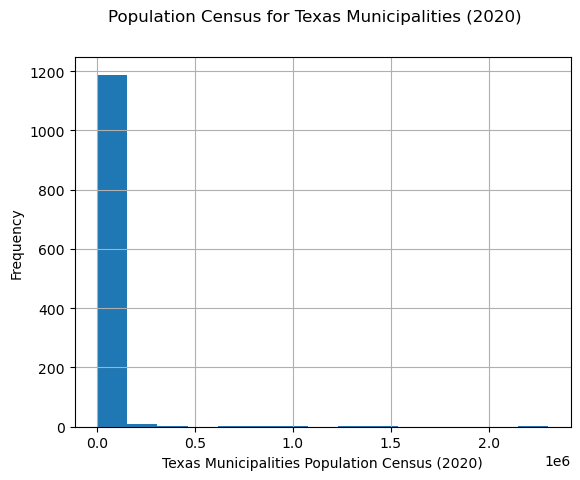

In [347]:
pop_census.hist(bins=15)
pl.suptitle("Population Census for Texas Municipalities (2020)")
pl.xlabel("Texas Municipalities Population Census (2020)")
pl.ylabel("Frequency")

### Insights
- With 15 bins, the data appears to be skewed right
- Outliers appearing at 2.0 * 10^7 and beyond
- Median and IQR are recommended measures of center and spread

# Boxplot 

{'whiskers': [<matplotlib.lines.Line2D at 0x162853e7100>,
 'caps': [<matplotlib.lines.Line2D at 0x162853e76a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x162853a9df0>],
 'medians': [<matplotlib.lines.Line2D at 0x162853e7c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x162853e7f10>],
 'means': []}

Text(0.5, 0, 'Population Census for Texas Cities (2020)')

Text(0, 0.5, 'Population')

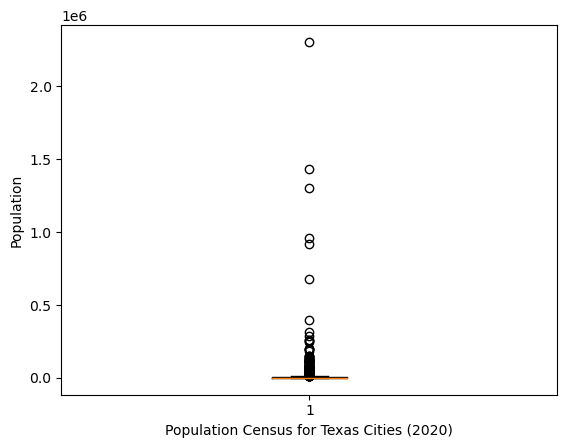

In [348]:
plt.boxplot(pop_census)

plt.xlabel("Population Census for Texas Cities (2020)")
plt.ylabel("Population")

## Insights from Boxplot
- There are outliers both mainly above the boxplot
- The distribution of the data is not normal
- Most data is concentrated between 0.0 and 0.5 * 10^7


# Bar Chart

<BarContainer object of 10 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Municipality of TX')

Text(0, 0.5, 'Pop Census (2020)')

Text(0.5, 1.0, 'Pop Census (2020) and Municipality of TX (Top 10)')

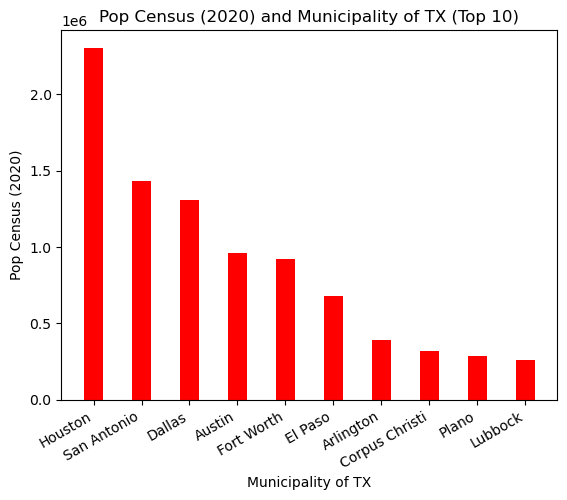

In [349]:
# Use a bar chart for plotting gross vs director_name
x_column = txpopulation_df["Municipality"]
y_column = txpopulation_df["2020 Census"]

selected_x = []
selected_y = []

for rows in range(10):
    selected_x.append(x_column[rows])
    selected_y.append(y_column[rows])
    

# Now plot our bar graph
plt.bar(selected_x, selected_y, color ='red', width =.4)
plt.xticks(rotation=30, ha='right')


plt.xlabel("Municipality of TX")
plt.ylabel("Pop Census (2020)")
plt.title("Pop Census (2020) and Municipality of TX (Top 10)")

### Insights
- Compared to the other cities, in 2020, Houston has the greatest population in the US, by a huge difference, which shows the reason for why the data was skewed
- Houston is the most populated, with San Antonio and Dallas coming in 2nd and 3rd most populated cities in Texas
- Austin is 4th most populated in Texas!
- The bar graph shows that most of the cities that are have a high population are near metroplexes